In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import     mean_squared_error


import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import export_text


%matplotlib inline

In [2]:
df=pd.read_csv("housing.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df=df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
# * Apply the log transform to `median_house_value`.
df=df.fillna(0)

df['median_house_value'] = df['median_house_value'].apply(lambda x: np.log1p(x))

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [4]:
df_val.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3138 non-null   float64
 1   latitude            3138 non-null   float64
 2   housing_median_age  3138 non-null   float64
 3   total_rooms         3138 non-null   float64
 4   total_bedrooms      3138 non-null   float64
 5   population          3138 non-null   float64
 6   households          3138 non-null   float64
 7   median_income       3138 non-null   float64
 8   median_house_value  3138 non-null   float64
 9   ocean_proximity     3138 non-null   object 
dtypes: float64(9), object(1)
memory usage: 245.3+ KB


In [5]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [6]:
df_train.shape, df_val.shape, df_test.shape

((9411, 9), (3138, 9), (3138, 9))

In [7]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# Decision  Tree

In [8]:
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(max_depth=1)
dt_regressor.fit(X_train, y_train)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


# Question 1
answer: ocean_proximity 

In [9]:
from sklearn.tree import export_text
print(export_text(dt_regressor, feature_names=list(dv.get_feature_names_out())))


|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [10]:
y_pred = dt_regressor.predict(X_val)

# Question 2
answer: 0.245

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf_params={ "n_estimators":10,
           "random_state": 1,
           "n_jobs": -1}
rf_regressor = RandomForestRegressor(**rf_params)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_val)
round(mean_squared_error(y_val, y_pred, squared=False),3)



0.245


# Question 3
Answer :160

In [12]:

scores = []
range_n_estimators = np.arange(10, 210, 10)

for n_est in range_n_estimators:
    rf_params={ "n_estimators":n_est,
           "random_state": 1,
           "n_jobs": -1}
    rf_regressor = RandomForestRegressor(**rf_params)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_val)
    rmse=round(mean_squared_error(y_val, y_pred, squared=False),3)
    scores.append((n_est,rmse))

    print('%4s -> %.3f' % (n_est, rmse))

       
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_scores


  10 -> 0.245
  20 -> 0.239
  30 -> 0.237
  40 -> 0.236
  50 -> 0.235
  60 -> 0.235
  70 -> 0.234
  80 -> 0.235
  90 -> 0.235
 100 -> 0.234
 110 -> 0.234
 120 -> 0.234
 130 -> 0.234
 140 -> 0.234
 150 -> 0.234
 160 -> 0.233
 170 -> 0.233
 180 -> 0.234
 190 -> 0.234
 200 -> 0.234


,n_estimators,RMSE
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.236
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.235
9,100,0.234


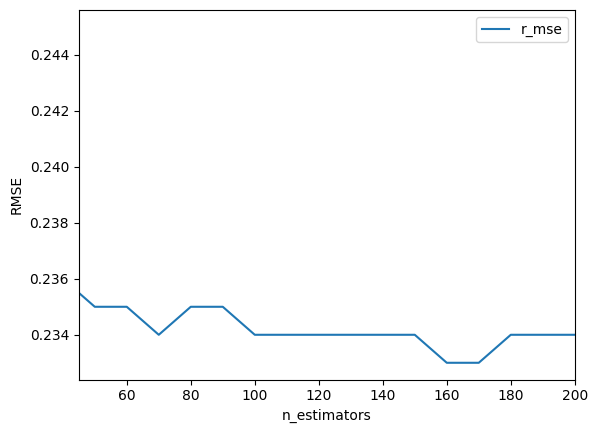

In [13]:
#@ INSPECTING THE RMSE SCORES:

plt.plot(df_scores.n_estimators, df_scores.RMSE, label='r_mse')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.xlim((45,200))
plt.legend();


# Question 4
answer 25

In [14]:
scores = []
max_depths=[10, 15, 20, 25]
range_n_estimators = np.arange(10, 210, 10)

for m_dpth in max_depths:
    for n_est in range_n_estimators:
        rf_params={ "n_estimators":n_est,
            "max_depth":m_dpth,
            "random_state": 1,
            "n_jobs": -1}
        rf_regressor = RandomForestRegressor(**rf_params)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_val)
        rmse=round(mean_squared_error(y_val, y_pred, squared=False),3)
        scores.append((m_dpth,n_est,rmse))

        print('max_depth %2s estimators: %4s-> %.3f' % (m_dpth,n_est, rmse))


       
df_scores2 = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'RMSE'])
df_scores2


max_depth 10 estimators:   10-> 0.251
max_depth 10 estimators:   20-> 0.248
max_depth 10 estimators:   30-> 0.246
max_depth 10 estimators:   40-> 0.245
max_depth 10 estimators:   50-> 0.246
max_depth 10 estimators:   60-> 0.245
max_depth 10 estimators:   70-> 0.245
max_depth 10 estimators:   80-> 0.246
max_depth 10 estimators:   90-> 0.246
max_depth 10 estimators:  100-> 0.245
max_depth 10 estimators:  110-> 0.245
max_depth 10 estimators:  120-> 0.245
max_depth 10 estimators:  130-> 0.245
max_depth 10 estimators:  140-> 0.245
max_depth 10 estimators:  150-> 0.245
max_depth 10 estimators:  160-> 0.245
max_depth 10 estimators:  170-> 0.244
max_depth 10 estimators:  180-> 0.245
max_depth 10 estimators:  190-> 0.245
max_depth 10 estimators:  200-> 0.245
max_depth 15 estimators:   10-> 0.246
max_depth 15 estimators:   20-> 0.240
max_depth 15 estimators:   30-> 0.238
max_depth 15 estimators:   40-> 0.236
max_depth 15 estimators:   50-> 0.236
max_depth 15 estimators:   60-> 0.236
max_depth 15

,max_depth,n_estimators,RMSE
0,10,10,0.251
1,10,20,0.248
2,10,30,0.246
3,10,40,0.245
4,10,50,0.246
...,...,...,...
75,25,160,0.233
76,25,170,0.233
77,25,180,0.234
78,25,190,0.234


In [15]:
df_scores2[df_scores2['RMSE']==df_scores2['RMSE'].min()]

,max_depth,n_estimators,RMSE
75,25,160,0.233
76,25,170,0.233


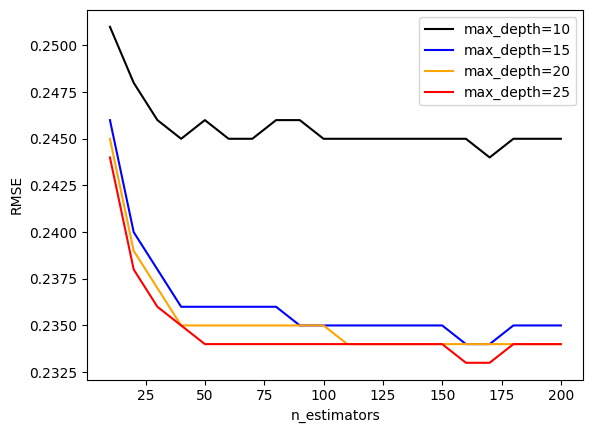

In [16]:
colors = ['black', 'blue', 'orange', 'red']

for dep, col in zip(max_depths, colors):
    df_subset = df_scores2[df_scores2.max_depth == dep]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             color=col,
             label='max_depth=%d' % dep)
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")

plt.legend()

# Question 5
answer median_income                

In [17]:
rf_params={ "n_estimators":10,
            "max_depth":20,
            "random_state": 1,
            "n_jobs": -1}

rf_regressor = RandomForestRegressor(**rf_params)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_val)
rmse=round(mean_squared_error(y_val, y_pred, squared=False),3)
print(rmse)

0.245


<Axes: >

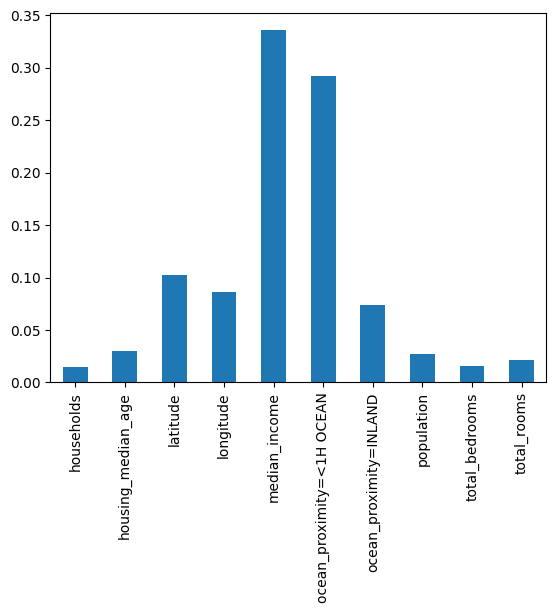

In [19]:
importances = rf_regressor.feature_importances_
forest_importances = pd.Series(importances, index= dv.feature_names_)
forest_importances.plot.bar()
         

In [20]:
forest_importances.sort_values(ascending=False)

median_income                0.335611
ocean_proximity=<1H OCEAN    0.292473
latitude                     0.102007
longitude                    0.086244
ocean_proximity=INLAND       0.073806
housing_median_age           0.030317
population                   0.027136
total_rooms                  0.021417
total_bedrooms               0.015852
households                   0.015136
dtype: float64

# Question 6
answer 'eta': 0.3

In [21]:
import xgboost as xgb

features = dv.feature_names_
features=[i.replace("=<","less_eq_") for i in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [22]:
#  'eta': 0.3, 
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val,y_pred, squared= False)
rmse

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630


[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	val-rmse:0.23847
[25]	train-rmse:0.17757	val-rmse:0.23830
[26]	train-rmse:0.17520	val-rmse:0.23862
[27]	train-rmse:0.17430	val-rmse:0.23807
[28]	train-rmse:0.17281	val-rmse:0.23793
[29]	train-rmse:0.17091	val-rmse:0.23683
[30]	train-rmse:0.16888	val-rmse:0.23570
[31]	train-rmse:0.16727	val-rmse:0.23505
[32]	train-rmse:0.16553	val-rmse:0.23494
[33]	train-rmse:0.16453	val-rmse:0.23476
[34]	train-rmse:0.16292	val-rmse:0.23490
[35]	train-rmse:0.16113	val-rmse:0.23416
[36]	train-rmse:0.15969	val-rmse:0.23402
[37]	train-rmse:0.15859	val-rmse:0.23362
[38]	train-rmse:0.15726	val-rmse:0.23393
[39]	train-rmse:

0.228623199980106

In [23]:
#  'eta': 0.1, 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val,y_pred, squared= False)
rmse

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269


[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	val-rmse:0.26141
[25]	train-rmse:0.23026	val-rmse:0.25997
[26]	train-rmse:0.22720	val-rmse:0.25799
[27]	train-rmse:0.22487	val-rmse:0.25620
[28]	train-rmse:0.22268	val-rmse:0.25494
[29]	train-rmse:0.22084	val-rmse:0.25374
[30]	train-rmse:0.21887	val-rmse:0.25266
[31]	train-rmse:0.21709	val-rmse:0.25172
[32]	train-rmse:0.21505	val-rmse:0.25075
[33]	train-rmse:0.21342	val-rmse:0.24991
[34]	train-rmse:0.21168	val-rmse:0.24882
[35]	train-rmse:0.21020	val-rmse:0.24826
[36]	train-rmse:0.20878	val-rmse:0.24779
[37]	train-rmse:0.20755	val-rmse:0.24731
[38]	train-rmse:

0.23208927121609343